In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import numpy as np
from scipy.stats import bernoulli
import statsmodels.api as sm
import pandas as pd


def simulate_ar(n, p, beta=0.5):
    """
    Simulate an AR(1) process.
    n: Number of observations
    p: Number of variables
    beta: AR(1) coefficient
    """
    X = np.zeros((n, p))
    for i in range(p):
        X[0, i] = np.random.normal()
        for j in range(1, n):
            noise = np.random.normal()
            X[j, i] = beta * X[j - 1, i] + noise
    return X

# def simulate_ar_V2(n, p, beta=0.5):
#     """
#     Simulate an AR(1) process.
#     n: Number of observations
#     p: Number of variables
#     beta: AR(1) coefficient
#     """
#     X = np.zeros((n, p))
#     for i in range(p):
#         X[i, 0] = np.random.normal()
#         for j in range(1, n):
#             noise = np.random.normal()
#             X[i,j ] = beta * X[i - 1, j] + noise
#     return X


def compute_settings_output(X):
    """
    Compute the output for the two settings.
    """
    output_setting_1 = compute_setting1_output(X)
    output_setting_2 = compute_setting2_output(X)
    return output_setting_1, output_setting_2


def compute_setting1_output(X):
    """
    Y | X ~ Bernoulli(0.5)
    """
    return bernoulli.rvs(0.5, size=X.shape[0])


def compute_setting2_output(X):
    """
    Y | X ~ Bernoulli(logit(0.08*(X2 + ... + X21)))
    """
    linear_combination = 0.08 * np.sum(X[:, 1:21], axis=1)
    probability = 1 / (1 + np.exp(-linear_combination))
    return bernoulli.rvs(probability)

In [41]:
## version with numpy array
import numpy as np
import statsmodels.api as sm


# Assuming simulate_ar, compute_setting1_output, and compute_setting2_output are defined elsewhere

def simulation(iterations=1000, n=500, p=200):
    """
    Simulate the two Random variables and fit the models.
    n: Number of observations
    p: Number of variables
    iterations: Number of iterations
    """
    # Assuming p-1 because we're excluding the intercept
    total_rows = iterations * 2
    results = np.empty((total_rows, 5), dtype=object)  # Pre-allocate NumPy array

    idx = 0
    for i in range(iterations):

        if i % 100 == 0: print(f"Reached iteration {i}..")
        try:
            xs = simulate_ar(n, p)
            #xs = simulate_ar_V2(n, p)

            ys1 = compute_setting1_output(xs)
            ys2 = compute_setting2_output(xs)

            model1 = sm.Logit(ys1, sm.add_constant(xs)).fit(disp=0)
            model2 = sm.Logit(ys2, sm.add_constant(xs)).fit(disp=0)

            # add only coeff beta1
            results[idx] = [i, 'Global Null', n, p, model1.pvalues[1]]
            idx += 1
            results[idx] = [i, '20 Nonzero Coefficients', n, p, model2.pvalues[1]]
            idx += 1

        except np.linalg.LinAlgError:
            print(f"Skipping iteration {i} due to singular matrix error.")
            continue

    return results


results1 = simulation(iterations=100)

Reached iteration 0..


KeyboardInterrupt: 

In [ ]:
simulation_df = pd.DataFrame(columns=['SimIdx', 'Setting', 'n', 'p', 'coeff_pvalue'], data=results1)

Text(0.5, 1.0, 'Hisgoragram of Beta1: Global Null')

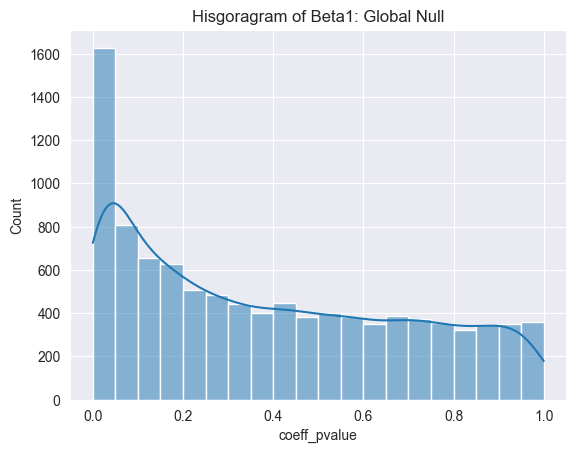

In [100]:
import seaborn as sns

sns.histplot(data=simulation_df[simulation_df['Setting'] == 'Global Null'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Hisgoragram of Beta1: Global Null')

Text(0.5, 1.0, 'Histogram of Beta1 : 20 Nonzero Coefficients')

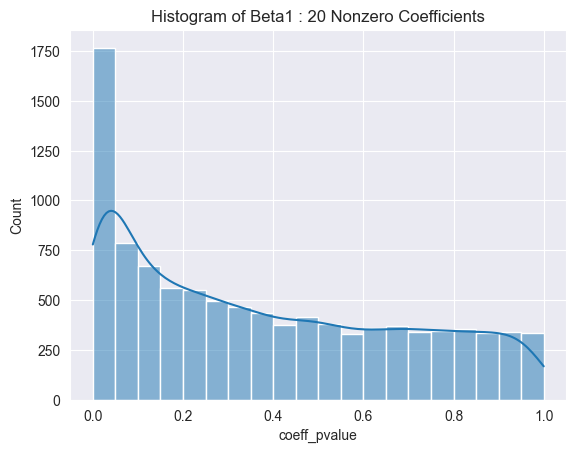

In [101]:
sns.histplot(data=simulation_df[simulation_df['Setting'] == '20 Nonzero Coefficients'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1 : 20 Nonzero Coefficients')

Text(0.5, 1.0, 'Histogram of Beta1: Both Settings')

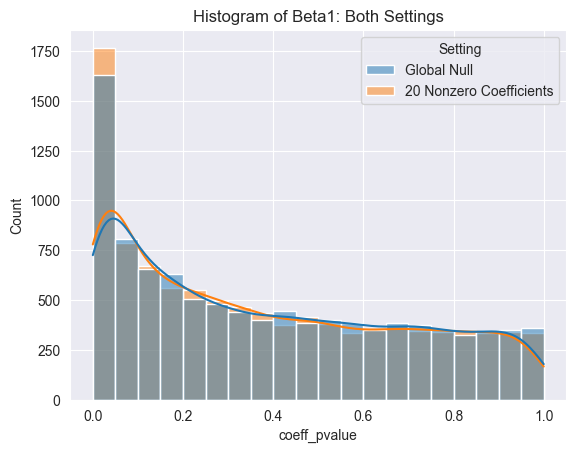

In [102]:
sns.histplot(data=simulation_df, x='coeff_pvalue', hue='Setting', kde=True, bins=20).set_title(
    'Histogram of Beta1: Both Settings')

### Conditional Randomization Test

In [53]:
import numpy as np
#np.random.seed(0)
def draw_sample(n = 500, p = 1, beta=0.5):
    X = np.zeros((n, p))
    for i in range(p):
        X[0, i] = np.random.normal()
        for j in range(1, n):
            noise = np.random.normal()
            X[j, i] = beta * X[j - 1, i] + noise
    return  X


def crt_test(X, y, original_coeff, j, k=1000):
    Xj = X[:, j].copy()
    permuted_coeffs = []
    for _ in range(k):
        #np.random.shuffle(X[:, j]) # sampling from uniform distribution (probably needs to be other distrubution)
        X[:,j] = draw_sample(n = 500, p = 1, beta=0.5)
        
        permuted_coeff = sm.Logit(y, sm.add_constant(X)).fit(disp=0).params[1]
        permuted_coeffs.append(permuted_coeff)
        X[:, j] = Xj
    N = np.sum(np.abs(permuted_coeffs) >= np.abs(original_coeff))

    one_sided = (1 / (k + 1))* (N + 1)
    p_value = 2 * min(one_sided, 1 - one_sided)

    return p_value

In [54]:
# Assuming simulate_ar, compute_setting1_output, and compute_setting2_output are defined elsewhere

def crt_simulation(iterations=100, n=500, p=200):
    """
    Simulate the two Random variables and fit the models.
    n: Number of observations
    p: Number of variables
    iterations: Number of iterations
    """
    # Assuming p-1 because we're excluding the intercept
    total_rows = iterations * 2
    results = np.empty((total_rows, 5), dtype=object)  # Pre-allocate NumPy array

    idx = 0
    for i in range(iterations):

        if i % 100 == 0: print(f"Reached iteration {i}..")
        try:
            xs = simulate_ar(n, p)
            #xs = simulate_ar_V2(n, p)

            ys1 = compute_setting1_output(xs)
            ys2 = compute_setting2_output(xs)

            model1 = sm.Logit(ys1, sm.add_constant(xs)).fit(disp=0)
            model2 = sm.Logit(ys2, sm.add_constant(xs)).fit(disp=0)

            crt_value1_setting1 = crt_test(xs, ys1, model1.params[1],1, k=10000)
            crt_value1_setting2 = crt_test(xs, ys2, model2.params[1],1,k=10000)
            
            
            # add only coeff beta1
            results[idx] = [i, 'Global Null', n, p, crt_value1_setting1]
            idx += 1
            results[idx] = [i, '20 Nonzero Coefficients', n, p, crt_value1_setting2]
            idx += 1

        except np.linalg.LinAlgError:
            print(f"Skipping iteration {i} due to singular matrix error.")
            continue

    return results

crt_results = simulation(iterations=1000)

Reached iteration 0..
Reached iteration 100..
Reached iteration 200..
Reached iteration 300..
Reached iteration 400..
Reached iteration 500..
Reached iteration 600..
Reached iteration 700..
Reached iteration 800..
Reached iteration 900..


Text(0.5, 1.0, 'Histogram of Beta1: Global Null')

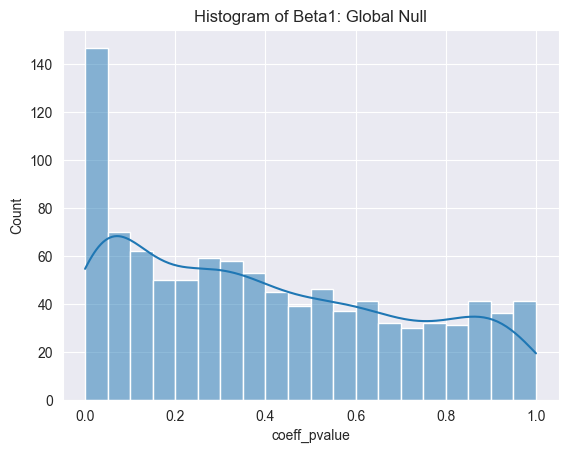

In [55]:
simulation_df = pd.DataFrame(columns=['SimIdx', 'Setting', 'n', 'p', 'coeff_pvalue'], data=crt_results)
import seaborn as sns

sns.histplot(data=simulation_df[simulation_df['Setting'] == 'Global Null'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1: Global Null')

Text(0.5, 1.0, 'Histogram of Beta1 : 20 Nonzero Coefficients')

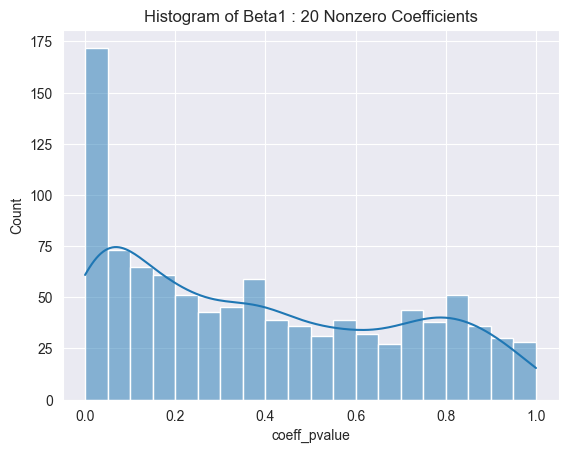

In [56]:
sns.histplot(data=simulation_df[simulation_df['Setting'] == '20 Nonzero Coefficients'], x='coeff_pvalue', kde=True,
             bins=20).set_title('Histogram of Beta1 : 20 Nonzero Coefficients')